In [14]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU'
device_name = 'CPU' 
print(f'device name {device_name}')
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree


import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

import copy



%config Completer.use_jedi = False

device name CPU


In [3]:
import Guided_Midpoint_Buttress as gmp

device name CPU


In [82]:
def generate_pos_circle(start, stop, h=30, k=0, r=30, num_points= 100):
    """Generate guide points originating a the origin for a circle, positive values only. """
    #(x-h)^2 + (y-k)^2 = r^(2)
    # y = sqrt(r^2-(x-h^2))+k
    x = np.linspace(start,stop,num=num_points)
    z = np.sqrt(np.square(r)-np.square(x-h))+k
    y = np.zeros_like(x)
    return np.concatenate((x.reshape((-1,1)),y.reshape((-1,1)),z.reshape((-1,1))),axis=1)

circ_gp = generate_pos_circle(0,60,h=30,k=0,r=30, num_points= 500)

In [83]:
start_hel, gep= gmp.get_reference_input(batch=3000 )

In [84]:
circ_gp.shape

(500, 3)

In [85]:
out_ep = gmp.build_protein_on_guide(start_hel, circ_gp, batch=100, 
                                 next_mp_dist = 9, mp_deviation_limit = 5)

max next indices 11
(3000, 8, 3)
Input Size:  300000
Passing Filters:  1000
final pass filter 921
max next indices 62
(921, 8, 3)
Input Size:  92100
Passing Filters:  1000
final pass filter 628
max next indices 133
(628, 8, 3)
Input Size:  62800
Passing Filters:  1000
final pass filter 646
max next indices 203
(646, 8, 3)
Input Size:  64600
Passing Filters:  1000
final pass filter 592
max next indices 270
(592, 8, 3)
Input Size:  59200
Passing Filters:  1000
final pass filter 654
max next indices 347
(654, 8, 3)
Input Size:  65400
Passing Filters:  1000
final pass filter 669
max next indices 416
(669, 8, 3)
Input Size:  66900
Passing Filters:  626
final pass filter 274
max next indices 460
(274, 8, 3)
Input Size:  27400
Passing Filters:  534
final pass filter 376
max next indices 493
(376, 8, 3)
Input Size:  37600
Passing Filters:  367
final pass filter 181
max next indices 499
(181, 8, 3)
Input Size:  18100
Passing Filters:  464
final pass filter 325
max next indices 499
(181, 8, 3)
I

In [49]:
gmp.vp(out_ep[0],circ_gp,max_out=100)

 PyMOL not running, entering library mode (experimental)


In [48]:
len(out_ep[1])

IndexError: list index out of range

In [11]:
sumL = 0

for x in out_ep:
    sumL += len(x)
print(sumL)

414


In [20]:
import LoopEndpoints as le

In [62]:
def add_loops(end_points, neighbors=10, length_mod=1, dist_cut=6, phiQueryNum=10, randMult=10, maxPhi_cut=20,
              uniquePhi=True, verbose=False, maxReruns = 4):
    """Chains first_helix, first_loop, second helix and the iteratively loop_then_helix to add all loops to endpoints."""
    
    epIn = end_points.copy()
    size = int(len(epIn)/2) #number of helixes represented by helical endpoints
    
   
    bL, iL, epGuide = le.first_helix(epIn,length_mod=length_mod)
    if verbose:
        print(f'first helix: #{iL.shape[0]}')
    
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    bL, iL, epGuide, epTrue, phiList, loopFeature, xform_True = le.first_loop(bL, iL, epGuide, 
                                                                neighbors=neighbors, phiQueryNum=phiQueryNum,
                                                                           randMult=randMult, distCut=dist_cut)
    if verbose:
        print(f'first loop: #{iL.shape[0]}')
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    hnum=1
    bL, iL, epGuide, epTrue, phiList = le.second_helix(bL, iL, epGuide, epTrue, phiList, hnum, loopFeature, 
                                                   xform_True, length_mod=length_mod, distCut=dist_cut)
    if verbose:
        print(f'second helix: #{iL.shape[0]}')
    
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    repeatNumber = 0 
    hnum = 0
    
    bL_s = []
    iL_s = []
    epGuide_s = []
    epTrue_s = []
    phiList_s =  []
    for x in range(0,(size-1)):
        bL_s.append([])
        iL_s.append([])
        epGuide_s.append([])
        epTrue_s.append([])
        phiList_s.append([])
        
    
    while hnum<(size-2):
        hnum += 1
        print('hnum',hnum)
        bL, iL, epGuide, epTrue, phiList = le.next_loop_helix(bL, iL, epGuide, epTrue, phiList, hnum, 
                neighbors=neighbors, phiQueryNum=phiQueryNum, randMult=randMult, distCut=dist_cut,length_mod=length_mod)
       
        bL_s[hnum] = copy.deepcopy(bL)
        iL_s[hnum] = iL.copy()
        epGuide_s[hnum] = epGuide.copy()
        epTrue_s[hnum] = epTrue.copy()
        phiList_s[hnum] = phiList.copy()
        
        if iL.shape[0] == 0:
            
            hnum = hnum - 2
            
            bL = bL_s[hnum] 
            iL = iL_s[hnum] 
            epGuide = epGuide_s[hnum] 
            epTrue = epTrue_s[hnum] 
            phiList = phiList_s[hnum] 
            
            neighbors += 5
            maxPhi_cut += 100
            
            repeatNumber += 1
            print('rn:', repeatNumber)
                
            if repeatNumber == maxReruns:
                if verbose:
                    print('fail2')
                return bL, iL, phiList, iL, iL, False
            
        if iL.shape[0] > maxPhi_cut:
            indexer = le.random_reduce(bL,num_to_keep = maxPhi_cut)
            bL = bL[indexer]
            iL = iL[indexer] 
            epGuide = epGuide[indexer]
            epTrue =  epTrue[indexer]
            phiList = phiList[indexer]
            if verbose:
                print(f'{hnum+2} helix: reduced to #{maxPhi_cut}')
        if verbose:
            print(f'{hnum+2} helix: #{iL.shape[0]}')
            
         
    #only return proteins with a unique set of loops queried from different phi bins
    if uniquePhi:
        phiList, u_indices = np.unique(phiList,axis=0,return_index=True)
        epGuide = epGuide[u_indices]
        epTrue = epTrue[u_indices]
        iL = iL[u_indices]
        bL = bL[u_indices]
    
    return bL, iL, phiList, epGuide, epTrue, True

In [63]:
end_points = out_ep[0][0]
length_mod=1
dist_cut=6
phiQueryNum=10
neighbors = 10
randMult=10
maxPhi_cut=20
verbose= True

In [64]:
end_points.shape

(40, 3)

In [70]:
bL, iL, phiList, iL, iL, suc= add_loops(end_points, neighbors=50, length_mod=3, dist_cut=6, phiQueryNum=10, randMult=0, maxPhi_cut=50,
              uniquePhi=True, verbose=True, maxReruns=10)

first helix: #7
first loop: #741
second helix: #163
hnum 1
3 helix: reduced to #50
3 helix: #50
hnum 2
4 helix: reduced to #50
4 helix: #50
hnum 3
rn: 1
3 helix: reduced to #150
3 helix: #150
hnum 2
4 helix: reduced to #150
4 helix: #150
hnum 3
5 helix: #13
hnum 4
6 helix: reduced to #150
6 helix: #150
hnum 5
7 helix: #15
hnum 6
8 helix: #46
hnum 7
9 helix: #41
hnum 8
10 helix: #19
hnum 9
11 helix: #51
hnum 10
12 helix: reduced to #150
12 helix: #150
hnum 11
13 helix: reduced to #150
13 helix: #150
hnum 12
14 helix: reduced to #150
14 helix: #150
hnum 13
15 helix: reduced to #150
15 helix: #150
hnum 14
16 helix: reduced to #150
16 helix: #150
hnum 15
17 helix: reduced to #150
17 helix: #150
hnum 16
18 helix: reduced to #150
18 helix: #150
hnum 17
19 helix: reduced to #150
19 helix: #150
hnum 18
20 helix: #27


In [73]:
outDirec= 'output/'
x='alpha'
for num,prot in enumerate(bL):
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

In [72]:
len(bL)

7

In [12]:
import GenerateEndpoints as ge

In [54]:
epr = ge.EP_Recon(out_ep[0])

In [55]:
eprn = epr.to_npose()

In [56]:
hll = np.array(epr.helixLength_list)
hll.shape

(5, 20)

In [35]:
eprn.shape

(388,)

In [41]:
clash_num = []
for x in range(len(eprn)):
    clash_num.append(le.whole_prot_clash_check(eprn[x],hll[x]))

In [43]:

%config Completer.use_jedi = False
import matplotlib.pyplot as plt

(array([ 12.,  14.,   0.,  71.,   0., 150., 117.,   0.,  22.,   2.]),
 array([ 4. ,  4.6,  5.2,  5.8,  6.4,  7. ,  7.6,  8.2,  8.8,  9.4, 10. ]),
 <BarContainer object of 10 artists>)

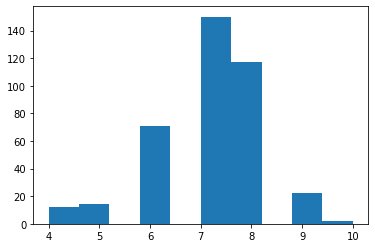

In [44]:
plt.hist(clash_num)

In [ ]:
#correlate this with successful loopings

In [57]:
outDirec= 'output/'
x='alpha'
for num,prot in enumerate(eprn):
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

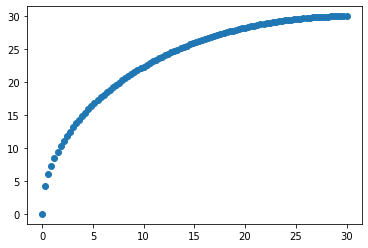

In [26]:
plt.scatter(circ_gp[:,0],circ_gp[:,2])